## Special Topics - Introduction to Deep Learning

#### Prof. Thomas da Silva Paula

### Fine-tuning example

* Using Keras
* Using Inception v3
* Using subset of images from Intel Image Classification (https://www.kaggle.com/puneet6060/intel-image-classification)

## Imports

In [14]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import *

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

from keras.models import Model
from keras.layers import Dense
from keras.layers import GlobalAveragePooling2D
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

from keras.preprocessing import image
from keras.utils import to_categorical

plt.rcParams['figure.figsize'] = [15, 5]

## Exploring the dataset

In [2]:
def create_data_list(path):
    files = []
    labels = []

    for f in tqdm(os.listdir(path)):
        f_path = os.path.join(path, f)

        for i in os.listdir(f_path):
            i_path = os.path.join(f_path, i)

            files.append(i_path)
            labels.append(f)

    return files, labels

In [30]:
training_path = '[your_path]]/seg_train_1000'
test_path = '[your_path]/seg_test_300'

train_files, train_labels = create_data_list(training_path)
test_files, test_labels = create_data_list(test_path)

100%|██████████| 6/6 [00:00<00:00, 662.00it/s]


In [31]:
print('Train ', len(train_files), len(train_labels))
print('Test ', len(test_files), len(test_labels))

Train  6000 6000
Test  300 300


In [70]:
print(np.unique(train_labels))

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


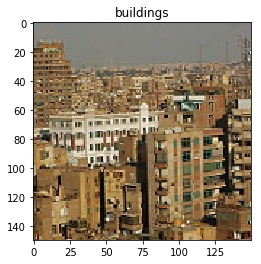

In [32]:
idx = 33
img_path = train_files[idx]
label = train_labels[idx]

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.title(label)
plt.imshow(img)

## Preparing the data

In [4]:
def preprocess_data(images, labels):
  
    X = []
    y = []

    for img_path, l in tqdm(zip(images, labels)):
        img = image.load_img(img_path, target_size=(224, 224))
        img = image.img_to_array(img)
        img = preprocess_input(img)

        X.append(img)
        y.append(l)

    return np.asarray(X), np.asarray(y)

In [37]:
X_train, y_train = preprocess_data(train_files, train_labels)
X_test, y_test = preprocess_data(test_files, test_labels)

6000it [24:44,  4.04it/s]
300it [00:00, 467.88it/s]


In [38]:
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (6000, 224, 224, 3) (6000,)
Test: (300, 224, 224, 3) (300,)


### Converting labels to integers

In [47]:
le = LabelEncoder()
le.fit(y_train)

LabelEncoder()

In [49]:
y_train = le.transform(y_train)
y_test = le.transform(y_test)

print('Train:', y_train.shape)
print('Test:', y_test.shape)

Train: (6000,)
Test: (300,)


In [50]:
y_train[0]

0

### Converting integers to one-hot encoding

In [51]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

print('Train:', y_train.shape)
print('Test:', y_test.shape)

Train: (6000, 6)
Test: (300, 6)


In [52]:
y_train[0]

array([1., 0., 0., 0., 0., 0.], dtype=float32)

### Saving data to disk

In [0]:
with open('/content/gdrive/My Drive/Datasets/train.npy', 'wb') as f:
    np.save(f, X_train)

In [0]:
with open('/content/gdrive/My Drive/Datasets/X_test.npy', 'wb') as f:
    np.save(f, X_test)

In [0]:
with open('/content/gdrive/My Drive/Datasets/y_train.npy', 'wb') as f:
    np.save(f, y_train)

In [0]:
with open('/content/gdrive/My Drive/Datasets/y_test.npy', 'wb') as f:
    np.save(f, y_test)

In [103]:
!ls -lh /content/gdrive/My\ Drive/Datasets/

total 3.7G
drwx------ 8 root root 4.0K May  2 01:39 seg_test_300
-rw------- 1 root root 4.3M May  2 01:35 seg_test_300.zip
drwx------ 8 root root 4.0K May  2 01:41 seg_train_1000
-rw------- 1 root root  86M May  2 01:37 seg_train_1000.zip
-rw------- 1 root root    0 May  2 21:48 train.npy
-rw------- 1 root root 173M May  2 21:48 X_test.npy
-rw------- 1 root root 3.4G May  2 21:48 X_train.npy
-rw------- 1 root root 7.2K May  2 21:48 y_test.npy
-rw------- 1 root root 141K May  2 21:48 y_train.npy


## Creating the model

In [5]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(6, activation='softmax', name='preds')(x)

new_model = Model(inputs=base_model.input, outputs=predictions)

Instructions for updating:
Colocations handled automatically by placer.


In [6]:
for layer in base_model.layers:
    layer.trainable = False

In [7]:
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
new_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
batch_normalization_20 (BatchNo (None, None, None, 6 192         conv2d_20[0][0]                  
__________________________________________________________________________________________________
batch_normalization_22 (BatchNo (None, None, None, 6 192         conv2d_22[0][0]                  
__________________________________________________________________________________________________
batch_normalization_25 (BatchNo (None, None, None, 9 288         conv2d_25[0][0]                  
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, None, None, 6 192         conv2d_26[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, None, None, 6 0           batch_normalization_20[0][0]     
__________

__________________________________________________________________________________________________
batch_normalization_41 (BatchNo (None, None, None, 1 576         conv2d_41[0][0]                  
__________________________________________________________________________________________________
batch_normalization_44 (BatchNo (None, None, None, 1 576         conv2d_44[0][0]                  
__________________________________________________________________________________________________
batch_normalization_49 (BatchNo (None, None, None, 1 576         conv2d_49[0][0]                  
__________________________________________________________________________________________________
batch_normalization_50 (BatchNo (None, None, None, 1 576         conv2d_50[0][0]                  
__________________________________________________________________________________________________
activation_41 (Activation)      (None, None, None, 1 0           batch_normalization_41[0][0]     
__________

batch_normalization_74 (BatchNo (None, None, None, 1 576         conv2d_74[0][0]                  
__________________________________________________________________________________________________
activation_74 (Activation)      (None, None, None, 1 0           batch_normalization_74[0][0]     
__________________________________________________________________________________________________
conv2d_71 (Conv2D)              (None, None, None, 1 147456      mixed7[0][0]                     
__________________________________________________________________________________________________
conv2d_75 (Conv2D)              (None, None, None, 1 258048      activation_74[0][0]              
__________________________________________________________________________________________________
batch_normalization_71 (BatchNo (None, None, None, 1 576         conv2d_71[0][0]                  
__________________________________________________________________________________________________
batch_norm

                                                                 mixed9_1[0][0]                   
                                                                 concatenate_2[0][0]              
                                                                 activation_94[0][0]              
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 2048)         0           mixed10[0][0]                    
__________________________________________________________________________________________________
preds (Dense)                   (None, 6)            12294       global_average_pooling2d_1[0][0] 
Total params: 21,815,078
Trainable params: 12,294
Non-trainable params: 21,802,784
__________________________________________________________________________________________________


## Training

In [58]:
history = new_model.fit(X_train, y_train,
                        validation_data=(X_test, y_test),
                        batch_size=32,
                        epochs=10)

Train on 6000 samples, validate on 300 samples
Epoch 1/10
6000/6000 [==============================] - 23s 4ms/step - loss: 0.8161 - acc: 0.7207 - val_loss: 0.5868 - val_acc: 0.7967
Epoch 2/10
6000/6000 [==============================] - 17s 3ms/step - loss: 0.4874 - acc: 0.8302 - val_loss: 0.6214 - val_acc: 0.7867
Epoch 3/10
6000/6000 [==============================] - 17s 3ms/step - loss: 0.4256 - acc: 0.8482 - val_loss: 0.5431 - val_acc: 0.8167
Epoch 4/10
6000/6000 [==============================] - 17s 3ms/step - loss: 0.3964 - acc: 0.8597 - val_loss: 0.4460 - val_acc: 0.8300
Epoch 5/10
6000/6000 [==============================] - 17s 3ms/step - loss: 0.3647 - acc: 0.8723 - val_loss: 0.5163 - val_acc: 0.8333
Epoch 6/10
6000/6000 [==============================] - 17s 3ms/step - loss: 0.3447 - acc: 0.8743 - val_loss: 0.5455 - val_acc: 0.8267
Epoch 7/10
6000/6000 [==============================] - 17s 3ms/step - loss: 0.3481 - acc: 0.8738 - val_loss: 0.4304 - val_acc: 0.8667
Epoch 8/

In [0]:
#new_model.save_weights('fine_tuning.h5')

## Model already trained
Here, we assume our model is trained and we want to evaluate it with the already processed data.

#### Recreating the model
In this case we need to recreate the model and load our trained weights.

In [2]:
base_model = InceptionV3(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(6, activation='softmax', name='preds')(x)

new_model = Model(inputs=base_model.input, outputs=predictions)

Instructions for updating:
Colocations handled automatically by placer.


In [3]:
new_model.load_weights('fine_tuning.h5')

In [4]:
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#### Loading processed data
Loading our already processed data. In this case, we'll load only the test data.

In [5]:
with open('y_test.npy', 'rb') as f:
    y_test = np.load(f)
    
print(y_test.shape)

(300, 6)


In [6]:
with open('X_test.npy', 'rb') as f:
    X_test = np.load(f)
    
print(X_test.shape)

(300, 224, 224, 3)


We also redefine our classes to use in our plots since we didn't load the original data

In [7]:
classes = ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

## Evaluating our model

In [8]:
y_test_pred = new_model.predict(X_test, batch_size=32)

In [9]:
print('Before', y_test.shape, y_test_pred.shape)
print('Example', y_test[0])
print('')

y_test_int = np.argmax(y_test, axis=1)
y_test_pred_int = np.argmax(y_test_pred, axis=1)

print('After', y_test_int.shape, y_test_pred_int.shape)
print('Example', y_test_int[0])

Before (300, 6) (300, 6)
Example [1. 0. 0. 0. 0. 0.]

After (300,) (300,)
Example 0


In [15]:
print(classification_report(y_test_int, y_test_pred_int))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84        50
           1       1.00      0.94      0.97        50
           2       0.83      0.68      0.75        50
           3       0.68      0.82      0.75        50
           4       0.98      0.94      0.96        50
           5       0.83      0.90      0.87        50

   micro avg       0.85      0.85      0.85       300
   macro avg       0.86      0.85      0.85       300
weighted avg       0.86      0.85      0.85       300



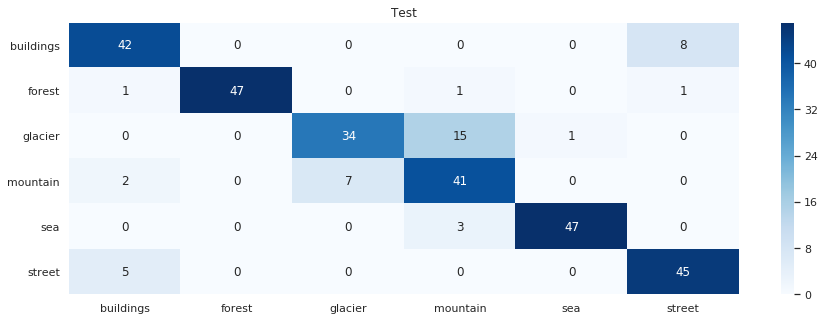

In [16]:
cm = confusion_matrix(y_test_int, y_test_pred_int)
sns.set()
plt.figure()
plt.title('Test')
sns.heatmap(cm, annot=True, yticklabels=classes, xticklabels=classes, cmap='Blues', fmt='d')

### Testing predictions

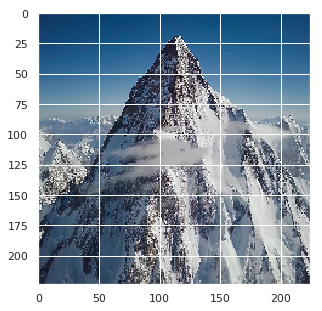

In [17]:
img_path = '../../sample_images/mountain.jpg'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)

In [18]:
img = image.img_to_array(img)
img = preprocess_input(img)

print(img.shape)

(224, 224, 3)


In [19]:
preds = new_model.predict(np.expand_dims(img, axis=0))
print(preds)

[[3.8350358e-06 1.4405246e-07 8.1024629e-01 1.8972209e-01 2.2526441e-08
  2.7617814e-05]]


<BarContainer object of 6 artists>

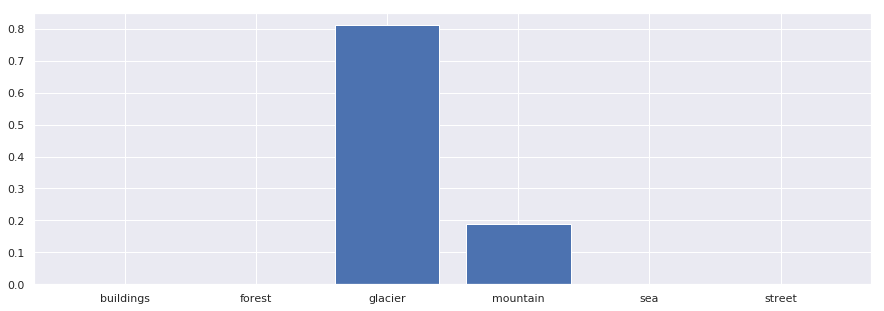

In [20]:
plt.bar(np.arange(0, len(preds[0])), preds[0], tick_label=classes)

### Another example

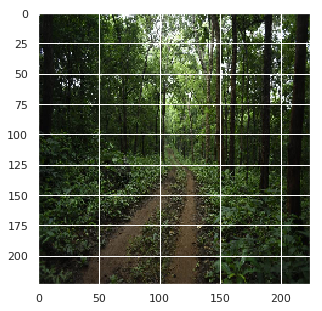

In [21]:
img_path = '../../sample_images/forest.jpg'
img = image.load_img(img_path, target_size=(224, 224))
plt.imshow(img)

In [22]:
img = image.img_to_array(img)
img = preprocess_input(img)

print(img.shape)

(224, 224, 3)


In [23]:
preds = new_model.predict(np.expand_dims(img, axis=0))
print(preds)

[[7.9866034e-09 9.9999607e-01 9.9896780e-10 3.3427630e-09 3.0832337e-10
  3.9376091e-06]]


<BarContainer object of 6 artists>

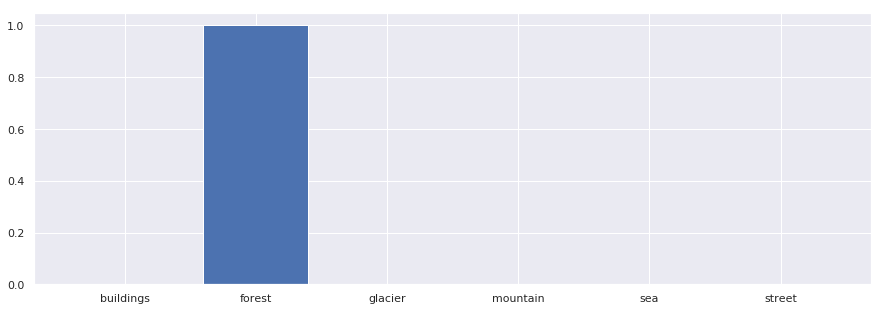

In [24]:
plt.bar(np.arange(0, len(preds[0])), preds[0], tick_label=classes)